<a href="https://colab.research.google.com/github/romenlaw/ML-playground/blob/main/ml_playground.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Intro
* **AI**
 * **Machine Learning** (ML) - the set of all tasks in which a computer can make decisions *based on data*.
   * **Deep Learning** (DL) - ML using neuro-net

**Reinforcement Learning (RL)** - ML in which no data is given, agent learns to perform task by interacting with env.

## Definitions:
* **Model** - rules on data and used to make predictions
* **Algorithm** - used to build the model
* **Feature** - data properties/characteristics that model uses for prediction
* **Label** - target feature of the prediction.
* **Predictions** - output of the model.
* **weights** - in the model formula, each feature is multiplied wby a corresponding factor (weight)
* **bias** - in the model formula, constant that is not attached to any features.
* **hyperparameters** - any quantity set before the training; e.g. learning rate, number of epochs, degree (of polynomial regression) etc.
* **parameter** - any quantity that the model creates/updates during training process

## Types of models and algorithms:
* **Supervised learning** - ML that works with labeled data. Supervised learning models:
  * **regression model** - predicts numerical data (outputs number)
  * **classification model** - predicts category (outputs category)
* **Unsupervised learning** - ML that works with unlabeled data. Unsupervised learning algos:
  * **clustering algos** - group data into clusters based on similarity. e.g.
    * **K-means clustering** - groups points by picking some random centers of mass and move them closer and closer to the points till the are at the right spots
    * **Hierarchical clustering** - starts by grouping the closest points together and continueing till we have some well-defined groups
    * **Density-based spatial clustering (DBSCAN)** - starts grouping points in places with high density, while labeling the isolated points as noise.
    * **Gaussian mixtrue models** - assignes fractions of the point to each of the existing clusters.
  * **dimentionality reduction** algos - similify data and faithfully describe it with fewer features
  * combination of clustering and dimensionality reduction. They express big matrix of data into product of smaller matrices
    * **Matrix factorization** - e.g. movie recommendation
    * **Single value decomposition** - uses linear algebra, e.g. image compression
  * **generative algos** - generate new data points that resemble the existing data
    * **Generative adversarial networks (GANs)**
    * **Variational autoencoders (VAEs)**
    * **Restricted Boltzmann machines (RBMs)**






In [2]:
!rm -f data/*
!wget -nv -P data https://raw.githubusercontent.com/luisguiserrano/manning/master/Chapter_03_Linear_Regression/Hyderabad.csv
!ls -al data
!wc -l data/Hyderabad.csv

2025-02-19 03:50:24 URL:https://raw.githubusercontent.com/luisguiserrano/manning/master/Chapter_03_Linear_Regression/Hyderabad.csv [253067/253067] -> "data/Hyderabad.csv" [1]
total 256
drwxr-xr-x 2 root root   4096 Feb 19 03:50 .
drwxr-xr-x 1 root root   4096 Feb 19 03:50 ..
-rw-r--r-- 1 root root 253067 Feb 19 03:50 Hyderabad.csv
2518 data/Hyderabad.csv


In [49]:
import random
import numpy as np
import matplotlib
from matplotlib import pyplot as plt
import pandas as pd
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import train_test_split

TOTAL_FRAMES = 50

def draw_line(slope, y_intercept, color='grey', linewidth=0.7, starting=0, ending=8):
    x = np.linspace(starting, ending, 1000)
    plt.plot(x, y_intercept + slope*x, linestyle='-', color=color, linewidth=linewidth)

def plot_points(features, labels):
    X = np.array(features)
    y = np.array(labels)
    plt.scatter(X, y)
    plt.xlabel('number of rooms')
    plt.ylabel('prices')

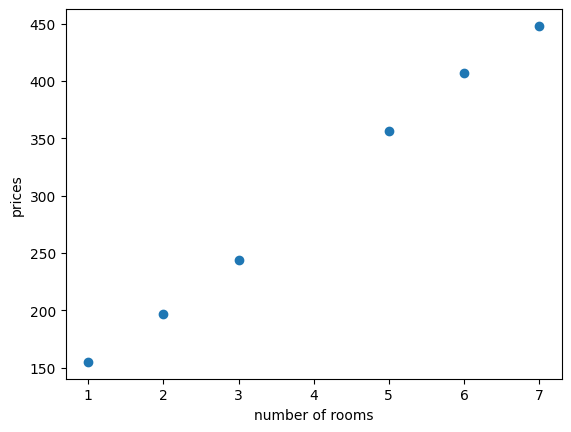

In [4]:
# load the data and plot them
features = np.array([1,2,3,5,6,7])
labels = np.array([155, 197, 244, 356, 407, 448])
plot_points(features, labels)

# Linear Regression
Drawing a line close to the data points. Start with random values for slope and y-intercept, rotate/move line based on formulae many times till it fits the points well. Each interation is called an **epoch**.

In the house price example:
* $p$: the price of a house in the dataset
* $\hat p$: the predicted price of a house
* $r$: number of rooms
* $m$: price per room
* $b$: base price of a house (bias?)

The linear regression model to predict house price: $\hat p=mr + b$

In [17]:
# simple trick
def simple_trick(base_price, price_per_room, num_rooms, price, learning_rate=0.1):
    small_random_1 = random.random()*learning_rate
    small_random_2 = random.random()*learning_rate
    predicted_price = base_price + price_per_room*num_rooms
    if price > predicted_price and num_rooms > 0:
        price_per_room += small_random_1
        base_price += small_random_2
    if price > predicted_price and num_rooms < 0:
        price_per_room -= small_random_1
        base_price += small_random_2
    if price < predicted_price and num_rooms > 0:
        price_per_room -= small_random_1
        base_price -= small_random_2
    if price < predicted_price and num_rooms < 0:
        price_per_room -= small_random_1
        base_price += small_random_2
    return price_per_room, base_price

# square trick - we use p-p_hat and r to reduce 4 cases into 1.
def square_trick(base_price, price_per_room, num_rooms, price, learning_rate):
  # print("in square_trick:", base_price, price_per_room, num_rooms, price, learning_rate)
  # p_hat = b + mr
  predicted_price = base_price + price_per_room * num_rooms
  # add lr*(p-p_hat) to b and obtain new b'
  base_price += learning_rate * (price - predicted_price)
  # add lr*r*(p-p_hat) to slope to get new m'. The r is used here because it provides
  # the sign (+/-). So the r(p-p_hat) always gives the right sign.
  price_per_room += learning_rate * num_rooms * (price-predicted_price)

  return price_per_room, base_price

# absolute trick - it's an intermediate between simple and square tricks
# here we only use r to reduce 4 cases into 2.
def absolute_trick(base_price, price_per_room, num_rooms, price, learning_rate):
  # p_hat = b + mr
  predicted_price = base_price + price_per_room * num_rooms
  if price > predicted_price: # p is above the line
    price_per_room += learning_rate * num_rooms # rotate line anti-clockwise
    base_price += learning_rate # move line up
  else: # p is below the line
    price_per_room -= learning_rate * num_rooms # rotate line clockwise
    base_price -= learning_rate # move line down

  return price_per_room, base_price


base price=99.6373481472713, price per room=50.735907601814475


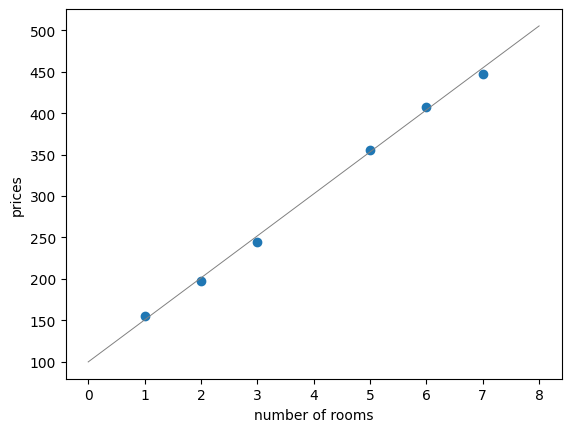

In [18]:
# linear regression algo using square trick
def linear_regression(features,  #1-D array of numbers of rooms
                      labels,   # 1-D array of house prices
                      learning_rate=0.01, epochs=1000,
                      error_fn=square_trick):
  ms, bs = [0.0] * epochs, [0.0] * epochs
  price_per_room = random.random() # float
  base_price = random.random()
  for epoch in range(epochs):
    i = random.randint(0, len(features)-1) # random index of dataset
    num_rooms = features[i]
    price = labels[i]

    # price_per_room, base_price = square_trick(base_price, price_per_room,
    #                                           num_rooms, price, learning_rate)
    price_per_room, base_price = error_fn(base_price, price_per_room, \
                                              num_rooms, price, learning_rate)
    ms[epoch] = price_per_room
    bs[epoch] = base_price

  return ms, bs # price_per_room, base_price
# apply the linear regression on the data
epochs = 10000
lr = 0.01 # a big learning rate will make the model explode
error_fn = square_trick
ms, bs = linear_regression(features, labels, learning_rate=lr, epochs=epochs,
                           error_fn=error_fn)
m, b = ms[-1], bs[-1]
print(f"base price={b}, price per room={m}")
plot_points(features, labels)
draw_line(m, b)

In [14]:
# linspace is no good because the 1st 50 epochs are where most changes happen
frames = np.linspace(0, epochs, TOTAL_FRAMES, dtype=np.uint32)
frames, len(frames)

(array([   0,  102,  204,  306,  408,  510,  612,  714,  816,  918, 1020,
        1122, 1224, 1326, 1428, 1530, 1632, 1734, 1836, 1938, 2040, 2142,
        2244, 2346, 2448, 2551, 2653, 2755, 2857, 2959, 3061, 3163, 3265,
        3367, 3469, 3571, 3673, 3775, 3877, 3979, 4081, 4183, 4285, 4387,
        4489, 4591, 4693, 4795, 4897, 5000], dtype=uint32),
 50)

In [15]:
# so I use logspace instead to show more epochs at the beginning
# I also want to show epoch 0, so hardcode it into the frames[]
frames = np.logspace(0, np.log10(epochs), TOTAL_FRAMES, dtype=np.uint32)
frames[:2] = 0
frames, len(frames)

(array([   0,    0,    1,    1,    2,    2,    2,    3,    4,    4,    5,
           6,    8,    9,   11,   13,   16,   19,   22,   27,   32,   38,
          45,   54,   64,   77,   91,  109,  129,  154,  183,  218,  260,
         309,  368,  438,  521,  621,  738,  879, 1046, 1244, 1480, 1762,
        2096, 2494, 2968, 3531, 4202, 4999], dtype=uint32),
 50)

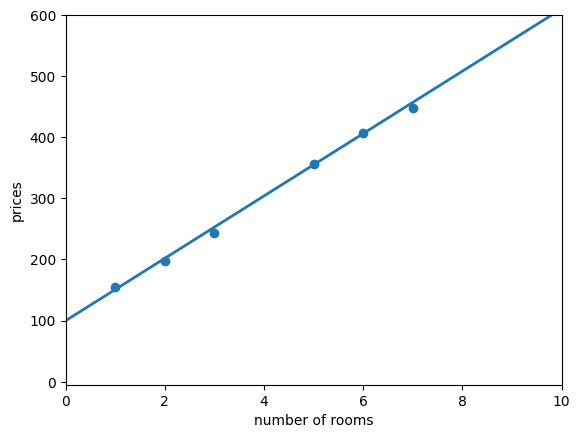

In [19]:
# check the progress of the training
from matplotlib.animation import FuncAnimation
from IPython.display import HTML

fig, ax = plt.subplots()
ax.set_xlim(0, 10)
ax.set_ylim(-5, 600)
ax.scatter(features, labels)
ax.set_xlabel('number of rooms')
ax.set_ylabel('prices')
# ax.set_xlim(0, 2 * np.pi)
# ax.set_ylim(-1, 1)
line, = ax.plot([], [], lw=2)

def init():
  line.set_data([], [])
  return line,

def update(frame):
  # idx = min(epochs-1, (frame+1)*frame_step_size) # linear scale
  idx = min(epochs-1, frames[frame])
  # print(f"frame={frame}, index={idx}")
  x = np.linspace(0, 10, 1000)
  y = ms[idx] * x + bs[idx]
  line.set_data(x, y)
  return line,

ani = FuncAnimation(fig, update, frames=TOTAL_FRAMES, init_func=init, blit=True)
HTML(ani.to_jshtml())

## Error Function
the Error/Cost/Loss function is a metric to tell how the model is doing.
* absolute error - sum of all vertical distances from the line to the points in dataset
* square error - sum of squares of these distances

Square error is used more commonly because it has much nicer derivative tha absolute value.

In practice, the *mean absolute error* (MAE) and *mean square error* (MSE) are much more commonly used. The mean (average) takes care of large datasets (otherwise, they would appear to have much bigger error than smaller dataset, since we only add the errors up).

*Root mean square error* (RMSE) take square root on MSE, this takes care of the unit of the error (matching the predictions unit, such as $).

base price=99.84721949181004, price per room=49.76684064090918


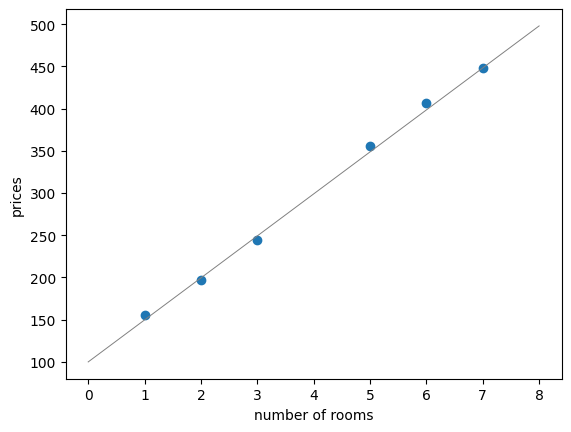

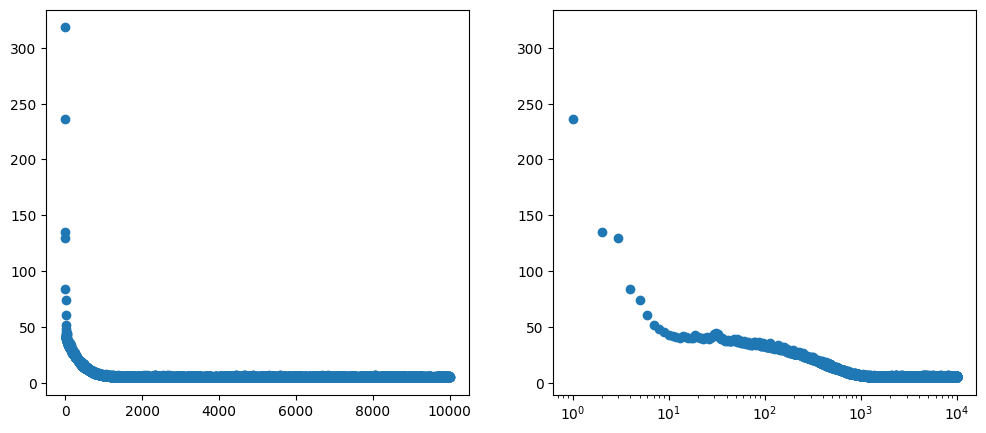

In [20]:
def scalar_rmse(labels, predictions): # they are both lists of scalars
  n = len(labels)
  diffs = np.subtract(labels, predictions)
  return np.sqrt(1.0 / n * (np.dot(diffs, diffs)))

# linear regression algo using square trick
def linear_regression(features,  #1-D array of numbers of rooms
                      labels,   # 1-D array of house prices
                      learning_rate=0.01, epochs=1000,
                      error_fn=square_trick):
  ms, bs, errs = [0.0] * epochs, [0.0] * epochs, [0.0] * epochs
  price_per_room = random.random() # float
  base_price = random.random()
  for epoch in range(epochs):
    i = random.randint(0, len(features)-1) # random index of dataset
    num_rooms = features[i]
    price = labels[i]
    predictions = features * price_per_room + base_price
    errs[epoch] = scalar_rmse(labels, predictions)
    # price_per_room, base_price = square_trick(base_price, price_per_room,
    #                                           num_rooms, price, learning_rate)
    price_per_room, base_price = error_fn(base_price, price_per_room, \
                                              num_rooms, price, learning_rate)
    ms[epoch] = price_per_room
    bs[epoch] = base_price

  return ms, bs, errs # price_per_room, base_price

epochs = 10000
lr = 0.01 # a big learning rate will make the model explode
error_fn = square_trick
ms, bs, errs = linear_regression(features, labels, learning_rate=lr, epochs=epochs,
                           error_fn=error_fn)
m, b = ms[-1], bs[-1]
print(f"base price={b}, price per room={m}")
plot_points(features, labels)
draw_line(m, b)
plt.show()
fig, (ax1, ax2) = plt.subplots(1,2, figsize=(12,5))
ax2.set_xscale('log')
# ax2.set_yscale('log')
ax2.scatter(range(len(errs)), errs)
ax1.scatter(range(len(errs)), errs)
plt.show()

By looking at the above error plot, we only need to train the model for 1000-2000 epochs.

## Stochastic and Batch Gradient Descent
Notice that the error can be calculated on the entire dataset or on just one point, but both may be expensive to do. So a middle ground is *mini-batch learning*:
* divide data into many mini-batches
* pick one of the mini-batches and do the training (adjust weights to reduce error in mini-batch)

3 general types of gradient descent algos:
1. using one point at a time - it's *stochastic gradient descent*
2. using mini-batch - it's called *mini-batch gradient descent*.
3. using entire dataset - it's called *batch gradient descent*.

## Example - House Pricing

In [10]:
data = pd.read_csv('data/Hyderabad.csv')

In [105]:
data.head()

,Price,Area,Location,No. of Bedrooms,Resale,MaintenanceStaff,Gymnasium,SwimmingPool,LandscapedGardens,JoggingTrack,...,LiftAvailable,BED,VaastuCompliant,Microwave,GolfCourse,TV,DiningTable,Sofa,Wardrobe,Refrigerator
0,6968000,1340,Nizampet,2,0,0,1,1,1,1,...,1,0,1,0,0,0,0,0,0,0
1,29000000,3498,Hitech City,4,0,0,1,1,1,1,...,1,0,1,0,0,0,0,0,0,0
2,6590000,1318,Manikonda,2,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,5739000,1295,Alwal,3,1,0,0,0,0,0,...,1,0,0,0,0,0,0,0,0,0
4,5679000,1145,Kukatpally,2,0,0,0,0,1,0,...,1,0,0,0,0,0,0,0,0,0


In [106]:
data.describe()

,Price,Area,No. of Bedrooms,Resale,MaintenanceStaff,Gymnasium,SwimmingPool,LandscapedGardens,JoggingTrack,RainWaterHarvesting,...,LiftAvailable,BED,VaastuCompliant,Microwave,GolfCourse,TV,DiningTable,Sofa,Wardrobe,Refrigerator
count,2.518000e+03,2518.000000,2518.000000,2518.000000,2518.000000,2518.000000,2518.000000,2518.000000,2518.000000,2518.000000,...,2518.000000,2518.000000,2518.000000,2518.000000,2518.000000,2518.000000,2518.000000,2518.000000,2518.000000,2518.000000
mean,9.818380e+06,1644.571088,2.623511,0.227562,0.412629,0.739873,0.709690,0.619142,0.559968,0.606434,...,0.975774,0.360207,0.607228,0.342732,0.330024,0.321287,0.334392,0.342335,0.341144,0.324861
std,8.777113e+06,746.256956,0.687330,0.419341,1.626445,1.611024,1.615231,1.624426,1.627686,1.625308,...,1.557725,1.622778,1.625256,1.621178,1.619894,1.618953,1.620347,1.621139,1.621023,1.619344
min,2.000000e+06,500.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,4.760000e+06,1160.000000,2.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,7.754000e+06,1500.000000,3.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,1.090000e+07,1829.000000,3.000000,0.000000,0.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,1.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
max,1.650000e+08,9400.000000,8.000000,1.000000,9.000000,9.000000,9.000000,9.000000,9.000000,9.000000,...,9.000000,9.000000,9.000000,9.000000,9.000000,9.000000,9.000000,9.000000,9.000000,9.000000


base price=-1.8289398112860875, price per room=6636.635301081148


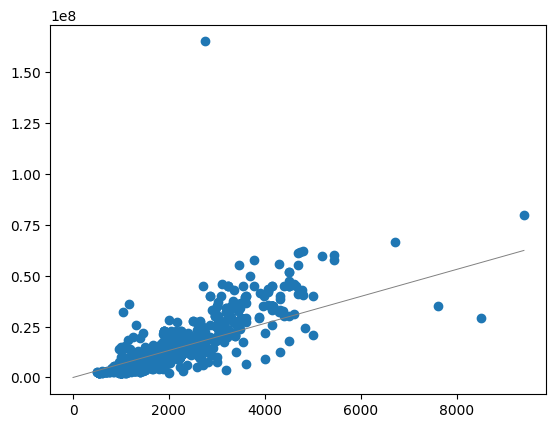

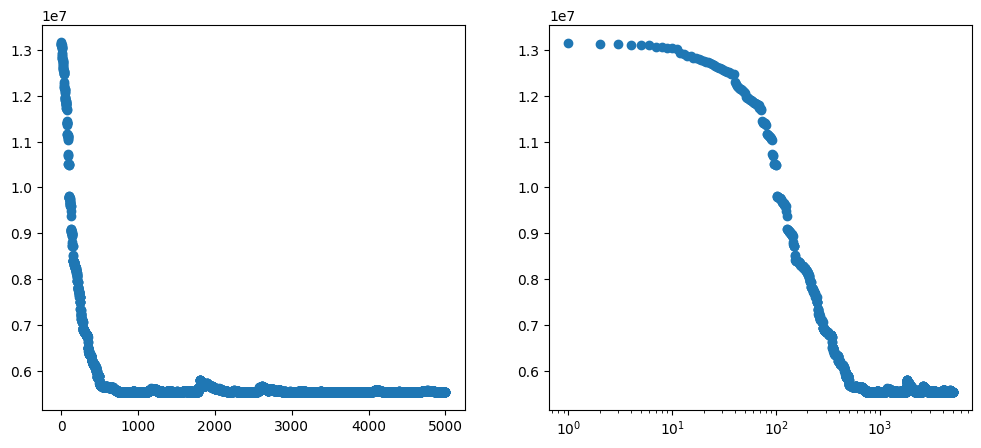

In [21]:
epochs = 5000
lr = 1e-9 # a big learning rate will make the model explode
error_fn = square_trick
x = data["Area"].values
y = data["Price"].values
ms, bs, errs = linear_regression(x, y, learning_rate=lr, epochs=epochs,
                           error_fn=error_fn)
m, b = ms[-1], bs[-1]
print(f"base price={b}, price per room={m}")
plt.scatter(x, y)
draw_line(m, b,starting=0, ending=max(x))
plt.show()
fig, (ax1, ax2) = plt.subplots(1,2, figsize=(12,5))
ax2.set_xscale('log')
# ax2.set_yscale('log')
ax2.scatter(range(len(errs)), errs)
ax1.scatter(range(len(errs)), errs)
plt.show()

In [42]:
x=data[["Area", "No. of Bedrooms"]].values
x

array([[1340,    2],
       [3498,    4],
       [1318,    2],
       ...,
       [2625,    3],
       [2050,    3],
       [1805,    3]])

In [36]:
x = data["Area"].values
x = np.expand_dims(x, axis=1)
x.shape, x

((2518, 1),
 array([[1340],
        [3498],
        [1318],
        ...,
        [2625],
        [2050],
        [1805]]))

## Generic Linear Regression
The general case will consists of a dataset of $m$ points and $n$ features.
* data points are $x^{(1)}, x^{(2)}, \ldots, x^{(m)}$. Each point is a vector $x^{(i)}=\left(x_1^{i}, x_2^{i}, \ldots, x_n^{i} \right)$
* the corresponding labels are $y_1, y_2, \ldots, y_m$
* weights of the model are $w_1, w_2, \ldots, w_n$
* bias is $b$

Vectorised version of the above functions.

m, n= 2518 2
base price=-1.5880572789291887, price per ...=6520.865522255047


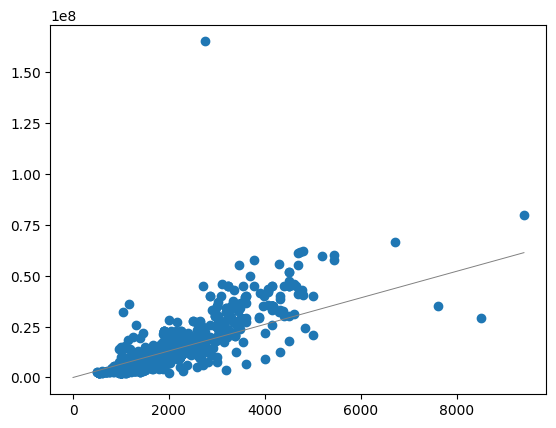

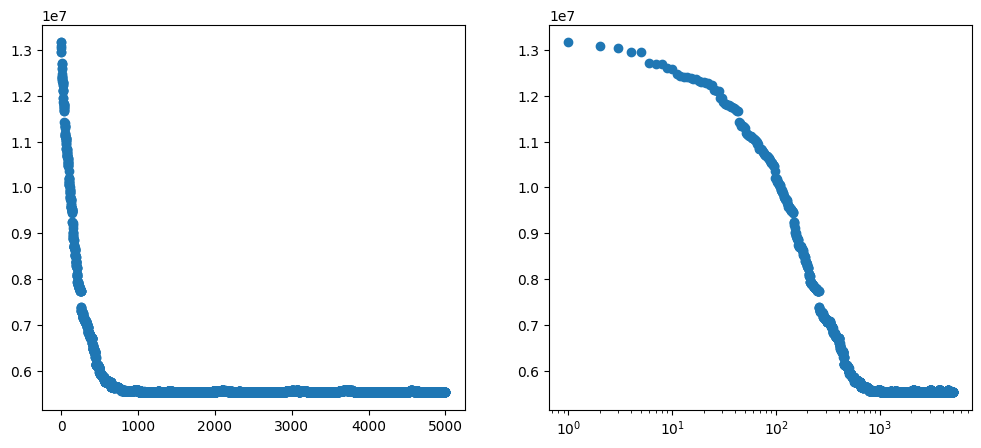

In [22]:
def general_square_trick(b, # scalar
                         w, # weights dim: (n)
                         x, # features dim: (n)
                         y, # labels dim: scalar
                         lr):
  y_hat = w.dot(x) + b

  delta = (y - y_hat) * lr # scalar

  b += delta
  w = w + x * delta # (n)

  return w, b

def rmse(labels, predictions):
    # n = labels.shape[0]
    # differences = np.subtract(labels, predictions)
    # return np.sqrt(1.0/n * (np.dot(differences, differences)))
    return np.sqrt(np.mean((predictions - labels) ** 2))

# linear regression algo using square trick
def general_linear_regression(X, # (m,n) a batch of x
                              Y, # (m) a batch of y
                              lr=0.01, epochs=1000):
  # pre-allocate the arrays since we know the size of them
  ws, bs, errs = [np.nan]*epochs, [np.nan]*epochs, [np.nan]*epochs
  m, n=X.shape
  w = np.random.rand(n)
  b = random.random()

  print("m, n=", m, n)

  for epoch in range(epochs):
    Y_hat = X.dot(w) + b
    np_rmse = rmse(Y, Y_hat) # notice we calc error on whole dataset
    errs[epoch]=np_rmse

    i = random.randint(0, m-1) # random index of dataset
    x = X[i]
    y = Y[i]

    w, b = general_square_trick(b, w, x, y, lr)
    ws[epoch] = w
    bs[epoch] = b
  return ws, bs, errs # price_per_room, base_price

epochs = 5000
lr = 1e-9 # a big learning rate will make the model explode
X = data[["Area", "No. of Bedrooms"]].values
# X = np.expand_dims(data["Area"].values, axis=1)
Y = data["Price"].values
ms, bs, errs = general_linear_regression(X, Y, lr=lr, epochs=epochs)

feature_idx=0 # 0=area, 1=no. bedrooms

m, b = ms[-1][feature_idx], bs[-1]
print(f"base price={b}, price per ...={m}")
plt.scatter(X[:,feature_idx], Y)
draw_line(m, b,starting=0, ending=max(X[:,feature_idx]))
plt.show()
fig, (ax1, ax2) = plt.subplots(1,2, figsize=(12,5))
ax2.set_xscale('log')
# ax2.set_yscale('log')
ax2.scatter(range(len(errs)), errs)
ax1.scatter(range(len(errs)), errs)
plt.show()

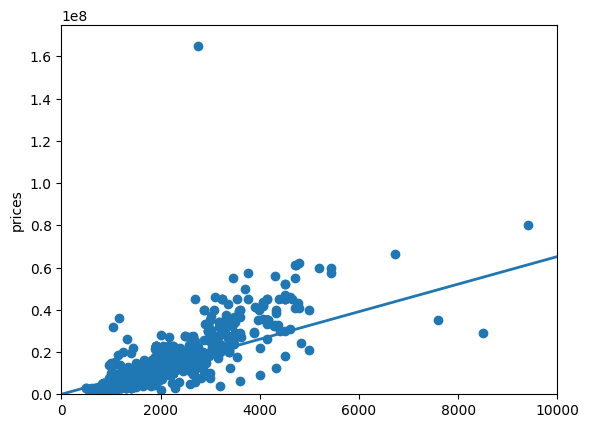

In [23]:
# check the progress of the training
from matplotlib.animation import FuncAnimation
from IPython.display import HTML

fig, ax = plt.subplots()
ax.set_xlim(0, 10000)
ax.set_ylim(-5, 1.75e8)
ax.scatter(X[:,feature_idx], Y)
# ax.set_xlabel('number of rooms')
ax.set_ylabel('prices')
line, = ax.plot([], [], lw=2)

def init():
  line.set_data([], [])
  return line,

def update(frame):
  # idx = min(epochs-1, (frame+1)*frame_step_size) # linear scale
  idx = min(epochs-1, frames[frame])
  # print(f"frame={frame}, index={idx}")
  x = np.linspace(0, 10000, 1000)
  y = ms[idx][feature_idx] * x + bs[idx]
  line.set_data(x, y)
  return line,

ani = FuncAnimation(fig, update, frames=TOTAL_FRAMES, init_func=init, blit=True)
HTML(ani.to_jshtml())

# Polynomial Regression
to model non-linear data.

The only difference is that we need to add more columns to our dataset before we apply linear regression. For example, if we decide to fit a polynomial of degree 3 to the data, we need to add two columns: one corresponding to the square of the feature and one corresponding to the cube of the feature.

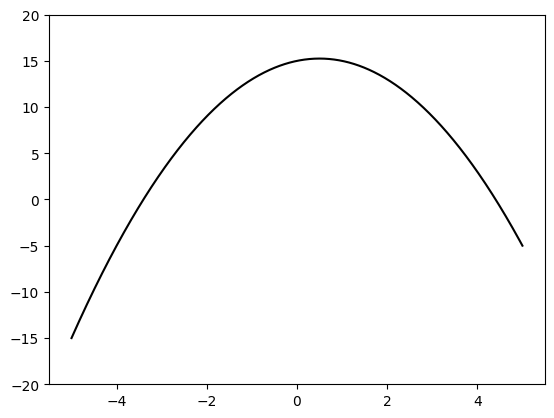

In [5]:
# Our original polynomial is -x^2+x+15
coefs = [15,1,-1]

def polynomial(coefs, x):
    n = len(coefs)
    return sum([coefs[i]*x**i for i in range(n)])

def draw_polynomial(coefs):
    n = len(coefs)
    x = np.linspace(-5, 5, 1000)
    plt.ylim(-20,20)
    plt.plot(x, sum([coefs[i]*x**i for i in range(n)]), linestyle='-', color='black')

draw_polynomial(coefs)

In [52]:
random.seed(0)
X = []
Y = []
for i in range(40):
    x = random.uniform(-5,5)
    y = polynomial(coefs, x) + random.gauss(0,2)
    X.append(x)
    Y.append(y)

In [53]:
X[:4], Y[:4]

([3.4442185152504816,
  -2.4108324970703663,
  0.11274721368608542,
  -1.9668727392107255],
 [6.685961311021467,
  4.690236225597948,
  12.205789026637378,
  11.133217991032268])

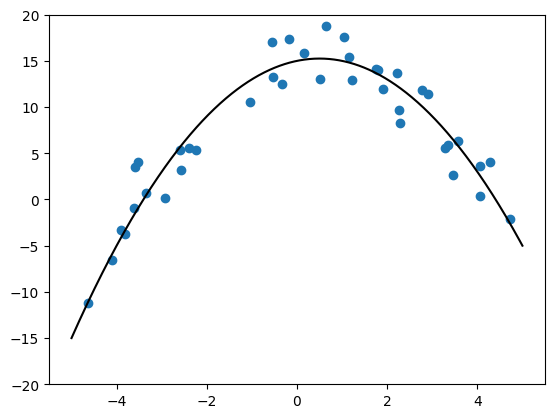

In [9]:
plt.scatter(X, Y)
draw_polynomial(coefs)

In [54]:
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.2, random_state=42)

# Reshape x to be a 2D array
X_train, Y_train = np.array(X_train)[:, np.newaxis], np.array(y_train)

In [88]:
x_poly.shape

(32, 22)

RMSE: 1.9145836120422892
R^2: 0.9440717991128924


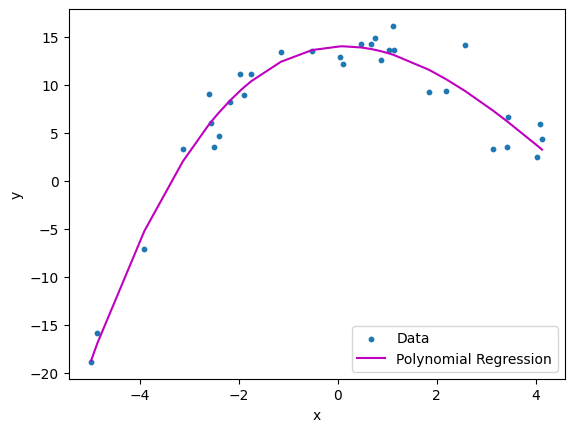

In [91]:
# Create polynomial features
polynomial_features = PolynomialFeatures(degree=3, interaction_only=False)
x_poly = polynomial_features.fit_transform(X_train)

# Fit the polynomial regression model
model = LinearRegression()
model.fit(x_poly, Y_train)
y_poly_pred = model.predict(x_poly)

# Evaluate the model
rmse = np.sqrt(mean_squared_error(Y_train, y_poly_pred))
r2 = r2_score(Y_train, y_poly_pred)
print(f"RMSE: {rmse}")
print(f"R^2: {r2}")

# Plot the results
plt.scatter(X_train, Y_train, s=10, label='Data')
x = X_train.squeeze()
idxs = np.argsort(x)

x, y_poly_pred = x[idxs], np.array(y_poly_pred)[idxs]
plt.plot(x, y_poly_pred, color='m', label='Polynomial Regression')
plt.xlabel('x')
plt.ylabel('y')
plt.legend()
plt.show()

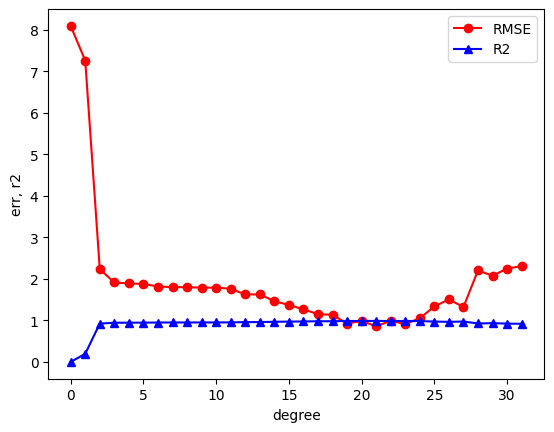

In [98]:
def polynomial_regression(X_train, Y_train, degree=1):
  # Create polynomial features
  polynomial_features = PolynomialFeatures(degree=degree, interaction_only=False)
  x_poly = polynomial_features.fit_transform(X_train)

  # Fit the polynomial regression model
  model = LinearRegression()
  model.fit(x_poly, Y_train)
  y_poly_pred = model.predict(x_poly)

  # Evaluate the model
  rmse = np.sqrt(mean_squared_error(Y_train, y_poly_pred))
  r2 = r2_score(Y_train, y_poly_pred)

  x = X_train.squeeze()
  idxs = np.argsort(x)

  x, y_poly_pred = x[idxs], np.array(y_poly_pred)[idxs]

  return x, y_poly_pred, rmse, r2

errs, r2s, xs, ys = [], [], [], []
num_degrees=32
for d in range(num_degrees):
  x, y, err, r2 = polynomial_regression(X_train, Y_train, degree=d)
  xs.append(x)
  ys.append(y)
  errs.append(err)
  r2s.append(r2)

# plot the results
plt.plot(np.arange(num_degrees), errs, color='r', marker='o', label='RMSE')
plt.plot(np.arange(num_degrees), r2s, color='b', marker='^', label='R2')
plt.xlabel('degree')
plt.ylabel('err, r2')
plt.legend()
plt.show()

In [94]:
errs, r2s

([1.9145836120422892,
  1.9145836120422892,
  1.9145836120422892,
  1.9145836120422892,
  1.9145836120422892,
  1.9145836120422892,
  1.9145836120422892,
  1.9145836120422892,
  1.9145836120422892,
  1.9145836120422892,
  1.9145836120422892,
  1.9145836120422892,
  1.9145836120422892,
  1.9145836120422892,
  1.9145836120422892,
  1.9145836120422892,
  1.9145836120422892,
  1.9145836120422892,
  1.9145836120422892,
  1.9145836120422892,
  1.9145836120422892,
  1.9145836120422892],
 [0.9440717991128924,
  0.9440717991128924,
  0.9440717991128924,
  0.9440717991128924,
  0.9440717991128924,
  0.9440717991128924,
  0.9440717991128924,
  0.9440717991128924,
  0.9440717991128924,
  0.9440717991128924,
  0.9440717991128924,
  0.9440717991128924,
  0.9440717991128924,
  0.9440717991128924,
  0.9440717991128924,
  0.9440717991128924,
  0.9440717991128924,
  0.9440717991128924,
  0.9440717991128924,
  0.9440717991128924,
  0.9440717991128924,
  0.9440717991128924])

# Optimise Training Process

## overfitting & underfitting

* Underfit - model is too simple to dataset (e.g. model of degree of 1, yet data fits better to parabola)
* fit the data well - model has the right amount of complexity for dataset
* Overfit - model is too complex for dataset

How to get computer to pick (learn) the right model? - by testing: break dataset into training set (80-90%) and testing set (10-20%).

|               | Training Set       | Testing Set |
|---------------|--------------------|-------------|
**Underfit model** | poor (large error) | poor |
**Good model**     | well (small error) | well |
**Overfit model**  | very well (very small) | poor |

Therefore, by looking at training and testing results, we know if model is overfit, underfit or good.

**Golden rule**: never use testing data for training

By using the testing data to pick a good model, we are already breaking the golden rule.

## Validation
To avoid using test data to validate the model (i.e. decide which model to pick), we break the dataset even further:
* **Training set**: for raining all our models
* **Validation set**: for making decisions on which odel to use
* **Testing set**: for checking how well our model did

It's common to split dataset to 60-20-20 or 80-10-10.

We pick the model that has smallest validation error.

## Model Complexity Graph

We plot the training error and validation error of each model, and look for the model with lowest validation error. i.e. x-axis is the complexity of the model (degree of polynomial); y-axis is error (e.g. MAE)

So this graph always has 2 curves.

## Regularization

A technique to avoid overfitting that doesn't require a testing set: *regularisation*.

When training with regularisation, we don't need to train several models. We train the model once, but during training, we use regularisation to improve the model's performance and reduce its complexity.

### Measuring how complex a model is: L1, L2 norm
From theory of $L^P$ spaces:
* **L1 norm**: sum of the absolute values of the coefficients
* **L2 norm**: sum of the squares of the coefficients
Bigger values -> more complex

### Modifying error function: Lasso regression, Ridge regression
The model's performance is measured by the error function, the complexity is measured by L1 or L2 norm. So, we have 2 quantities:
* **regression error** - measure of the quality of the model. It can be absolute or square errors (e.g. MAE, MSE, RMSE)
* **regularisation term** - measure of the complexity of the model. It can be L1 or L2 norm of model.

We modify the error to be:
$$\text{Error} = \text{Regression error} + \text{Regularisation term}
$$
The training process will try to minimise this modified error.

If L1 norm is used, the model is called *lasso regression*:
$$\text{Lasso regression Error} = \text{Regression error} + \text{L1 norm}
$$

If L2 norm is used, the model is called *ridge regression*:
$$\text{Ridge regression Error} = \text{Regression error} + \text{L2 norm}
$$
This approach results in a model with fewer coefficients. i.e. L1 reg turns some of the coefficients into 0.

This approach results in a model with smaller coefficients. i.e. L2 reg shrinks all the coefficients but rarely turns them into zero.

**Rule of thumb** to choose between L1 and L2 reg: if we have too many features and want to remove some of them, use L1 reg; if we have only few features and believe they are relevant, use L2.

## Reg parameter
Introduce a hyperparameter regularisation parameter, its goal is to determine if the model-training process should emphasize performance or simplicity.
$$\text{Error} = \text{Regression error} + \lambda\times\text{Regularisation term}
$$


* $\lambda=0$ : cancels out regularisation term, i.e. emphasize on performance
* large λ : emphasize on simplicity (lower degree) of model

It is typical to choose powers of 10, e.g. 10, 1, 0.1, 0.01.
